In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Function to add noise to images
def add_noise(img, noise_type="gaussian"):
    if noise_type == "gaussian":
        return img + 0.5 * torch.randn_like(img)  # Gaussian noise
    elif noise_type == "salt_pepper":
        s_vs_p = 0.5
        amount = 0.04
        noisy_img = img.clone()

        # Add salt noise (white pixels)
        num_salt = int(np.ceil(amount * img.numel() * s_vs_p))
        coords = [torch.randint(0, i, (num_salt,)) for i in img.shape]
        noisy_img[tuple(coords)] = 1

        # Add pepper noise (black pixels)
        num_pepper = int(np.ceil(amount * img.numel() * (1.0 - s_vs_p)))
        coords = [torch.randint(0, i, (num_pepper,)) for i in img.shape]
        noisy_img[tuple(coords)] = 0

        return noisy_img
    elif noise_type == "speckle":
        return img + img * torch.randn_like(img)  # Speckle noise


In [3]:
# Define transformation for dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_noise(x, noise_type="gaussian"))  # Apply Gaussian noise
])

# Load MNIST dataset with noisy images
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [4]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)  # Encode the input
        x = self.decoder(x)  # Decode the encoded representation
        return x

In [5]:
# Instantiate the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        img, _ = data
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

Epoch [1/5], Loss: 0.2869
Epoch [2/5], Loss: 0.2503
Epoch [3/5], Loss: 0.2446
Epoch [4/5], Loss: 0.2431
Epoch [5/5], Loss: 0.2425


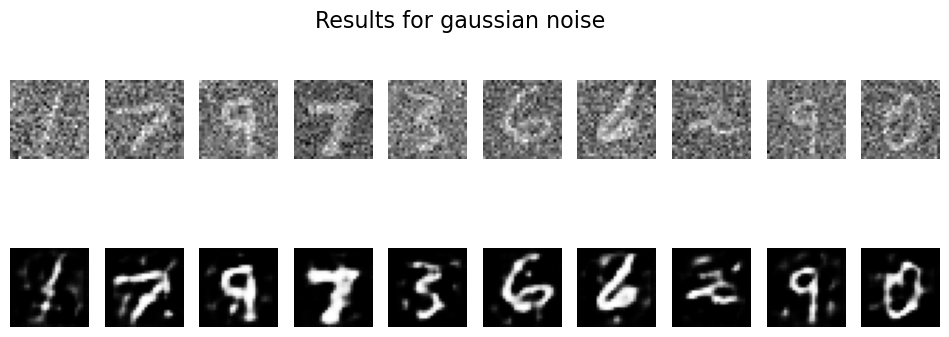

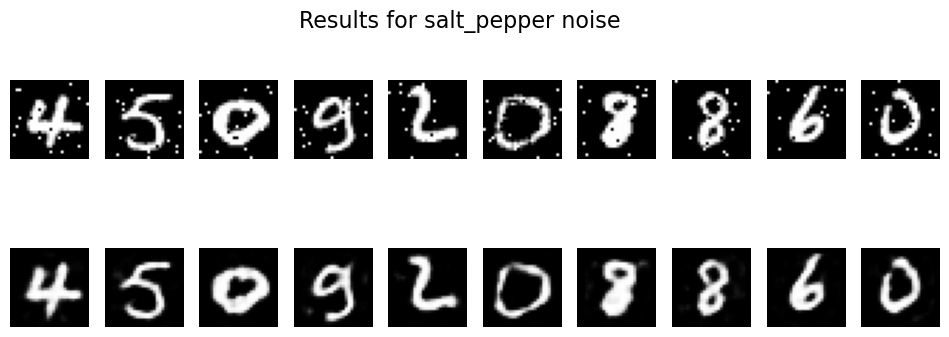

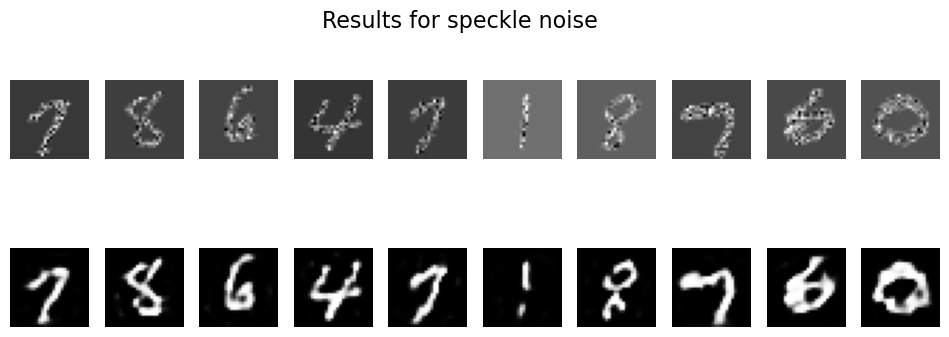

In [7]:
# Function to visualize results
def visualize_results(noise_type):
    # Reload dataset with the specific noise type
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_noise(x, noise_type=noise_type))
    ])
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)
    
    sample_data = next(iter(testloader))
    noisy_imgs, _ = sample_data
    denoised_imgs = model(noisy_imgs)
    
    # Plot the images
    fig, axes = plt.subplots(2, 10, figsize=(12, 4))
    fig.suptitle(f'Results for {noise_type} noise', fontsize=16)
    for i in range(10):
        # Noisy images
        axes[0, i].imshow(noisy_imgs[i].squeeze().detach().numpy(), cmap='gray')
        axes[0, i].axis('off')
        # Denoised images
        axes[1, i].imshow(denoised_imgs[i].squeeze().detach().numpy(), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

# Visualize results for different noise types
visualize_results("gaussian")
visualize_results("salt_pepper")
visualize_results("speckle")